In [1]:
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.append('..')

%env WORKDIR=/Users/jitang/Dev/workdir

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from eofs.xarray import Eof
import cartopy.crs as ccrs

from lib.reanalysis import r1
from lib import obs
from lib.plotting import maps
from lib.enso import oni_trimonthly

env: WORKDIR=/Users/jitang/Dev/workdir


In [2]:
sfo = obs.daily_summary('SFO', '1980-07-01', '2021-06-01')
sfo.loc[sfo.day == '2008-01-03', 'precip_in'] = 0.17
sfo.loc[sfo.day == '2008-01-04', 'precip_in'] = 2.10
sfo.loc[sfo.day == '2008-01-05', 'precip_in'] = 0.77
sfo.loc[sfo.precip_in < 0.1, 'precip_in'] = 0

data_cols = ['day', 'precip_in', 'max_temp_f', 'min_temp_f']

sfo_monthly = sfo[data_cols].resample('MS', on='day').agg({
    'precip_in': np.sum,
    'max_temp_f': np.mean,
    'min_temp_f': np.mean
}).reset_index()

djf = sfo_monthly[sfo_monthly.day.dt.month.isin([11, 12, 1, 2, 3])]

In [3]:
djf.precip_in.describe()

count    205.000000
mean       3.126049
std        2.641378
min        0.000000
25%        1.120000
50%        2.360000
75%        4.790000
max       13.520000
Name: precip_in, dtype: float64

In [4]:
dry_top50 = djf[djf.precip_in < djf.precip_in.mean() - 0.75*djf.precip_in.std()]
dry_top50.shape

(52, 4)

In [5]:
oni = oni_trimonthly()
dry_top50['month'] = dry_top50.day.dt.month
dry_top50['year'] = dry_top50.day.dt.year

oni_relevant = oni[['ANOM', 'MONTH', 'YR']]
oni_relevant.columns = ['ONI', 'month', 'year']
dry_top50 = dry_top50.merge(oni_relevant)

<ipython-input-5-6f758a56606e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dry_top50['month'] = dry_top50.day.dt.month
<ipython-input-5-6f758a56606e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dry_top50['year'] = dry_top50.day.dt.year


In [7]:
bbox = (0, 360, 90, 10)
_, _, dry_anoms = r1.hgt_monthly(500, yearmonths=dry_top50.day, bbox=bbox)

In [26]:
coslat = np.cos(np.deg2rad(dry_anoms.coords['lat'].values))
coslat[coslat < 0] = 0
wgts = np.sqrt(coslat)[..., np.newaxis]

solver = Eof(dry_anoms.hgt, weights=wgts)

# retrieve the first two EOFs from the solver class
eofs = solver.eofs(neofs=3)

In [27]:
solver.varianceFraction(neigs=3)

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.19993573, 0.1294001 , 0.10593829], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions

In [28]:
def plot_nhem_anoms(da, cmap, levels, title, draw=True, colorbar_label='Geopotential height anomaly (dm)'):
    proj = ccrs.NorthPolarStereo(central_longitude=-94.5, true_scale_latitude=None, globe=None)
    m = maps.CartopyMap(proj=proj)
    if draw:
        m.draw()
    m.plot.fill(da, cmap, levels, colorbar=True, colorbar_label=colorbar_label)
    m.textbox.bottom_right(title, fontsize=20)
    m.textbox.top_left('by Jim Tang (@wxmann)', fontsize=16)
    return m

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


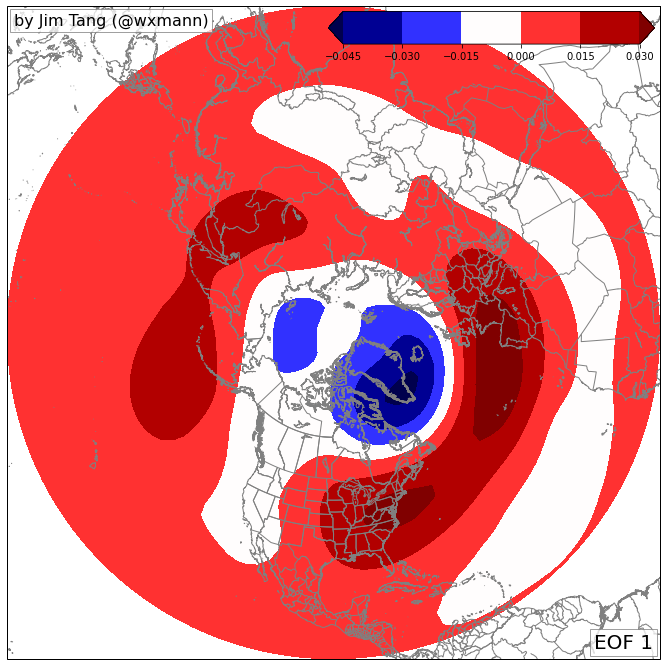

In [29]:
fig = plt.figure(figsize=(12, 12))

da = eofs[0]
cmap = 'seismic'
title = 'EOF 1'

m = plot_nhem_anoms(da, cmap, levels=None, title=title, draw=True, colorbar_label=None)

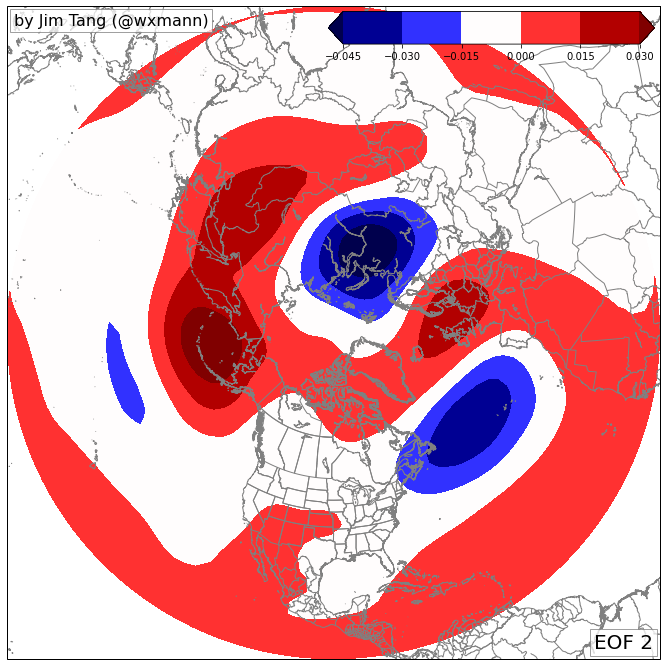

In [30]:
fig = plt.figure(figsize=(12, 12))

da = eofs[1]
cmap = 'seismic'
title = 'EOF 2'

m = plot_nhem_anoms(da, cmap, levels=None, title=title, draw=True, colorbar_label=None)

In [31]:
dry_top50

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI
0,1980-11-01,0.00,64.100000,47.600000,11,1980,0.11
1,1984-01-01,0.30,57.612903,45.516129,1,1984,-0.60
2,1985-01-01,0.67,52.258065,40.709677,1,1985,-1.04
3,1986-11-01,0.00,66.000000,48.133333,11,1986,1.14
4,1988-02-01,0.32,63.344828,45.965517,2,1988,0.54
5,1988-03-01,0.00,65.516129,47.290323,3,1988,0.14
6,1989-12-01,0.00,57.354839,43.096774,12,1989,-0.05
7,1990-03-01,0.70,59.483871,46.903226,3,1990,0.28
8,1990-11-01,0.14,64.166667,47.933333,11,1990,0.40
9,1991-01-01,0.20,57.064516,43.161290,1,1991,0.41


In [32]:
pcs = solver.pcs(pcscaling=1, npcs=2).to_dataframe().reset_index()
first_pc = pcs[pcs['mode'] == 0]
second_pc = pcs[pcs['mode'] == 1]
dry_with_pcs = dry_top50.merge(
    first_pc[['time', 'pcs']], left_on='day', right_on='time').merge(
    second_pc[['time', 'pcs']], on='time')

dry_with_pcs = dry_with_pcs.rename(columns={
    'pcs_x': 'pc1',
    'pcs_y': 'pc2'
})

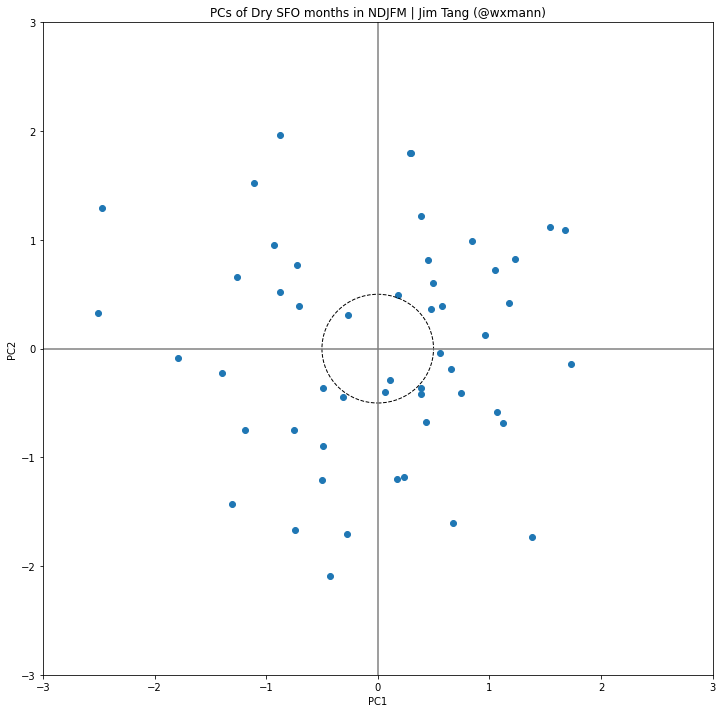

In [33]:
plt.figure(figsize=(12, 12))
plt.scatter(dry_with_pcs.pc1, dry_with_pcs.pc2)
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCs of Dry SFO months in NDJFM | Jim Tang (@wxmann)')
circ = plt.Circle((0, 0), 0.5, color='k', fill=False, ls='--')
plt.gca().add_patch(circ)

In [34]:
min_amplitude = 0.5
cod = dry_with_pcs.pc1 ** 2 + dry_with_pcs.pc2 ** 2 < min_amplitude ** 2
threshold = 0

q1 = dry_with_pcs[(dry_with_pcs.pc1 > threshold) & (dry_with_pcs.pc2 > threshold) & ~cod]
_, _, q1_anoms = r1.hgt_monthly(500, yearmonths=q1.day, bbox=bbox)

q2 = dry_with_pcs[(dry_with_pcs.pc1 < -threshold) & (dry_with_pcs.pc2 > threshold) & ~cod]
_, _, q2_anoms = r1.hgt_monthly(500, yearmonths=q2.day, bbox=bbox)

q3 = dry_with_pcs[(dry_with_pcs.pc1 < -threshold) & (dry_with_pcs.pc2 < -threshold) & ~cod]
_, _, q3_anoms = r1.hgt_monthly(500, yearmonths=q3.day, bbox=bbox)

q4 = dry_with_pcs[(dry_with_pcs.pc1 > threshold) & (dry_with_pcs.pc2 < -threshold) & ~cod]
_, _, q4_anoms = r1.hgt_monthly(500, yearmonths=q4.day, bbox=bbox)

In [43]:
default_levels = np.arange(-105, 106, 10)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


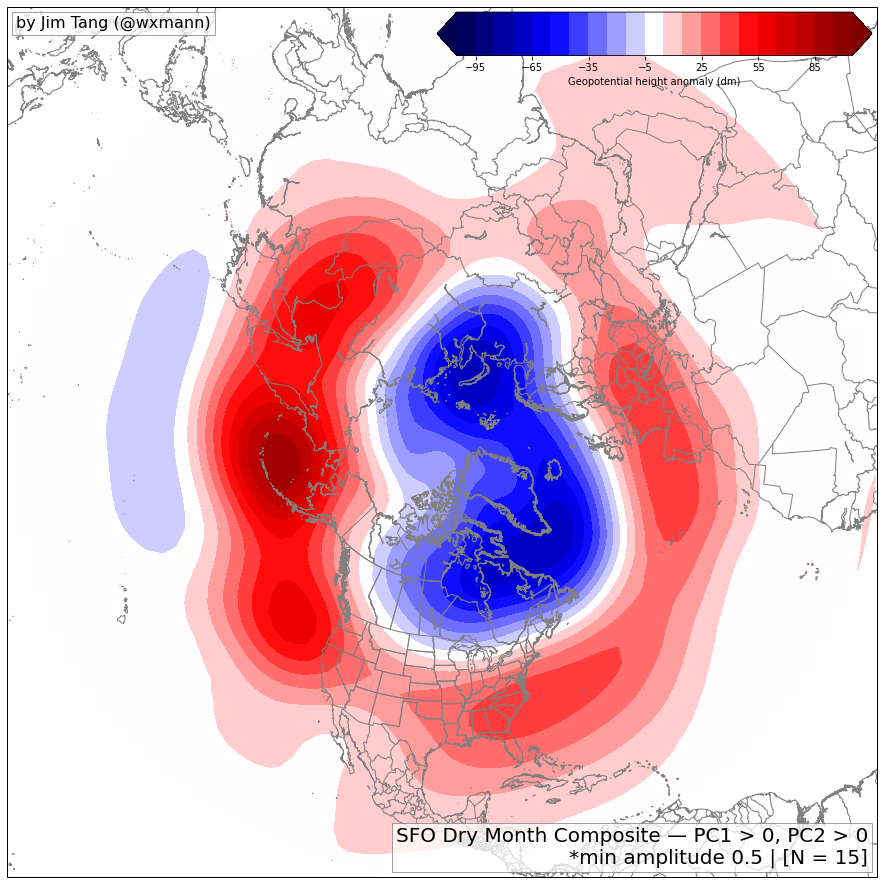

In [44]:
fig = plt.figure(figsize=(16, 16))

da = q1_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = default_levels
title = f'SFO Dry Month Composite — PC1 > 0, PC2 > 0\n*min amplitude {min_amplitude} | [N = {len(q1_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


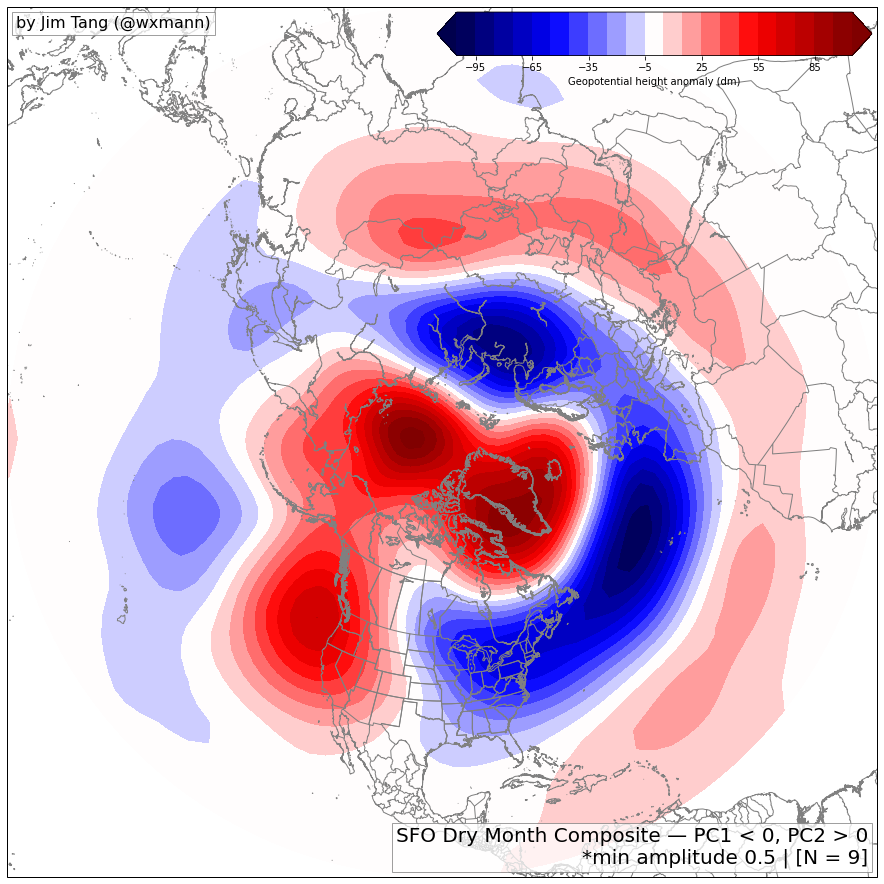

In [45]:
fig = plt.figure(figsize=(16, 16))

da = q2_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = default_levels
title = f'SFO Dry Month Composite — PC1 < 0, PC2 > 0\n*min amplitude {min_amplitude} | [N = {len(q2_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


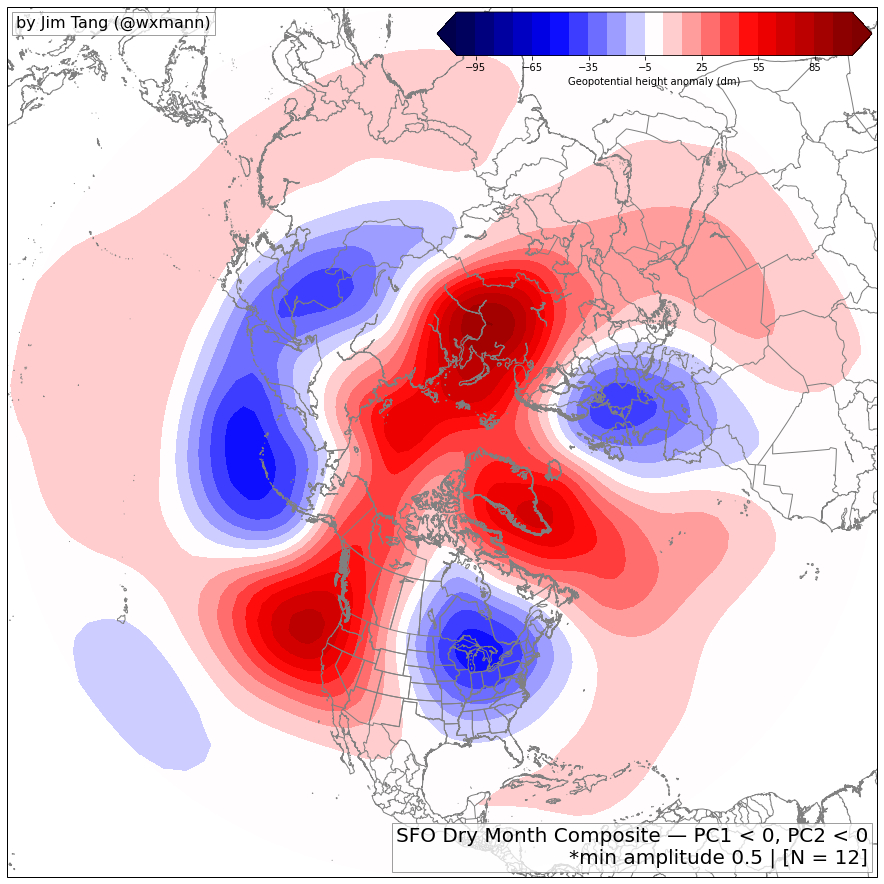

In [46]:
fig = plt.figure(figsize=(16, 16))

da = q3_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = default_levels
title = f'SFO Dry Month Composite — PC1 < 0, PC2 < 0\n*min amplitude {min_amplitude} | [N = {len(q3_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


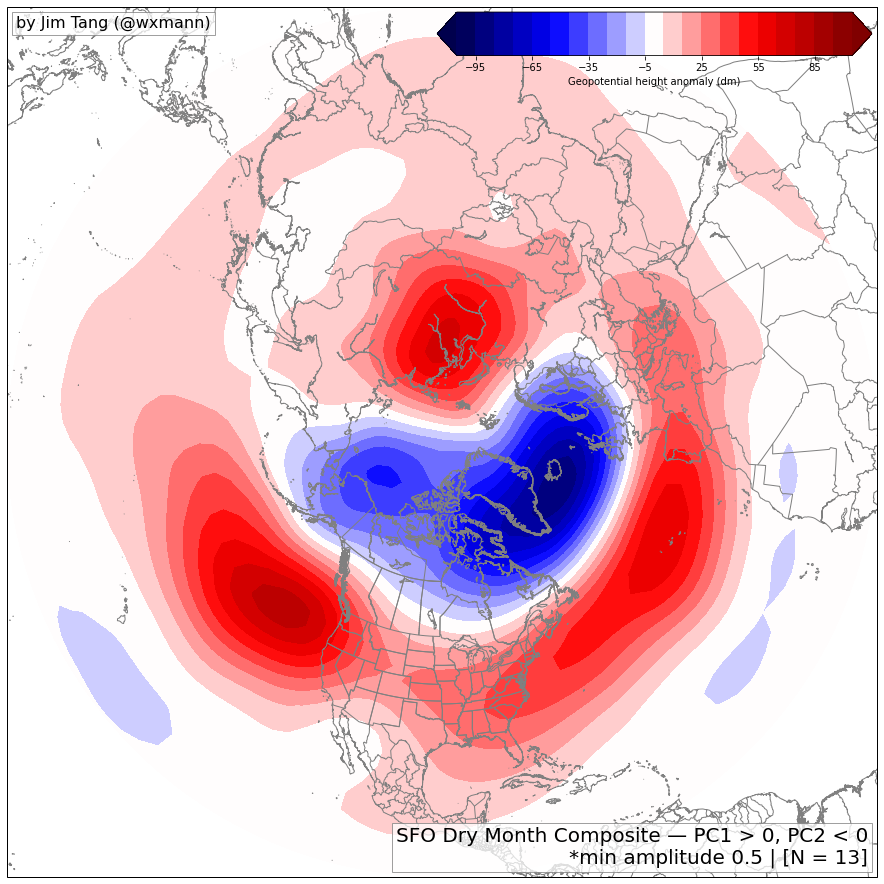

In [47]:
fig = plt.figure(figsize=(16, 16))

da = q4_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = default_levels
title = f'SFO Dry Month Composite — PC1 > 0, PC2 < 0\n*min amplitude {min_amplitude} | [N = {len(q4_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

In [48]:
q1

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI,time,pc1,pc2
7,1990-03-01,0.70,59.483871,46.903226,3,1990,0.28,1990-03-01,1.542038,1.118936
8,1990-11-01,0.14,64.166667,47.933333,11,1990,0.40,1990-11-01,0.291409,1.801771
9,1991-01-01,0.20,57.064516,43.161290,1,1991,0.41,1991-01-01,0.388349,1.215958
13,1995-02-01,0.38,59.392857,48.357143,2,1995,0.72,1995-02-01,0.498608,0.601961
15,1997-02-01,0.27,59.678571,47.321429,2,1997,-0.36,1997-02-01,1.179284,0.417485
16,1997-03-01,0.00,63.580645,48.129032,3,1997,-0.10,1997-03-01,0.451982,0.813556
17,1998-12-01,0.94,52.741935,41.580645,12,1998,-1.57,1998-12-01,0.480816,0.363684
24,2003-03-01,1.08,62.483871,49.161290,3,2003,0.38,2003-03-01,0.297944,1.799959
30,2008-03-01,0.10,60.712903,46.481290,3,2008,-1.29,2008-03-01,0.185242,0.495523
39,2013-11-01,0.91,64.733333,49.733333,11,2013,-0.17,2013-11-01,1.047298,0.721381


In [49]:
q2

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI,time,pc1,pc2
0,1980-11-01,0.00,64.100000,47.600000,11,1980,0.11,1980-11-01,-0.725735,0.771902
2,1985-01-01,0.67,52.258065,40.709677,1,1985,-1.04,1985-01-01,-2.506330,0.331752
6,1989-12-01,0.00,57.354839,43.096774,12,1989,-0.05,1989-12-01,-0.874712,1.960832
14,1995-11-01,0.00,66.300000,50.400000,11,1995,-1.00,1995-11-01,-1.104623,1.521825
22,2001-03-01,0.85,61.903226,48.870968,3,2001,-0.44,2001-03-01,-1.263476,0.660419
23,2003-01-01,1.09,58.806452,48.838710,1,2003,0.92,2003-01-01,-0.930738,0.949742
36,2013-01-01,0.10,55.612903,41.677419,1,2013,-0.43,2013-01-01,-0.708433,0.393161
38,2013-03-01,0.24,62.483871,46.774194,3,2013,-0.34,2013-03-01,-2.473718,1.292637
51,2021-02-01,1.10,63.178571,47.321429,2,2021,-0.93,2021-02-01,-0.872402,0.516932


In [50]:
q3

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI,time,pc1,pc2
4,1988-02-01,0.32,63.344828,45.965517,2,1988,0.54,1988-02-01,-0.744684,-1.665589
5,1988-03-01,0.00,65.516129,47.290323,3,1988,0.14,1988-03-01,-0.494692,-0.895364
20,2000-11-01,0.63,58.366667,46.533333,11,2000,-0.75,2000-11-01,-1.304395,-1.430084
21,2000-12-01,0.30,57.354839,45.709677,12,2000,-0.74,2000-12-01,-1.786386,-0.087559
26,2005-11-01,0.95,65.266667,49.133333,11,2005,-0.57,2005-11-01,-0.311265,-0.444206
29,2007-11-01,0.55,63.038000,48.488000,11,2007,-1.50,2007-11-01,-0.489104,-0.358799
33,2011-01-01,0.75,56.741935,44.258065,1,2011,-1.42,2011-01-01,-1.394117,-0.221888
35,2012-02-01,0.33,59.517241,45.068966,2,2012,-0.72,2012-02-01,-0.277152,-1.703652
37,2013-02-01,0.67,58.500000,43.214286,2,2013,-0.43,2013-02-01,-0.748694,-0.744985
41,2014-01-01,0.00,64.064516,46.129032,1,2014,-0.42,2014-01-01,-1.187941,-0.749840


In [51]:
q4

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI,time,pc1,pc2
1,1984-01-01,0.30,57.612903,45.516129,1,1984,-0.60,1984-01-01,0.678005,-1.600191
3,1986-11-01,0.00,66.000000,48.133333,11,1986,1.14,1986-11-01,0.747934,-0.409693
11,1992-11-01,0.00,64.000000,49.166667,11,1992,-0.28,1992-11-01,0.391987,-0.412796
12,1994-03-01,0.17,63.516129,48.129032,3,1994,0.17,1994-03-01,1.067293,-0.581828
18,1999-11-01,1.01,62.733333,50.700000,11,1999,-1.46,1999-11-01,0.388868,-0.362863
19,1999-12-01,0.39,58.032258,43.548387,12,1999,-1.65,1999-12-01,0.429056,-0.674232
27,2007-01-01,0.43,55.709677,40.322581,1,2007,0.66,2007-01-01,0.558871,-0.040143
28,2007-03-01,0.27,63.741935,47.516129,3,2007,-0.12,2007-03-01,0.659994,-0.187807
32,2009-11-01,0.18,64.566667,48.566667,11,2009,1.36,2009-11-01,0.176240,-1.198486
34,2011-12-01,0.00,56.516129,41.838710,12,2011,-1.04,2011-12-01,1.379220,-1.730592
